In [3]:
full_data = (
    order_details
    .merge(orders, on='OrderID')
    .merge(customers, on='CustomerID')
    .merge(products, on='ProductID')
)

print(f"Σύνολο εγγραφών: {len(full_data)}")
full_data.head()

Σύνολο εγγραφών: 2947


,OrderDetailID,OrderID,ProductID,Ποσότητα,Τιμή_Μονάδας,Έκπτωση_%,Επιστροφή,Βαθμολογία,CustomerID,Ημερομηνία_Παραγγελίας,...,Όνομα_Προϊόντος,Κατηγορία,Υποκατηγορία,Τιμή,Κόστος,Ποσότητα_Απόθεμα,Ελάχιστο_Απόθεμα,Προμηθευτής,Χώρα_Προέλευσης,Εγγύηση_Μήνες
0,1,ORD000001,PROD00060,2,458.77,8.6,False,3.0,CUST00090,2023-01-04,...,Προϊόν_PROD00060,Ρούχα,Ανδρικά,458.77,114.46,177,7,Προμηθευτής_B,Ελλάδα,6
1,2,ORD000001,PROD00074,7,424.53,18.4,True,2.0,CUST00090,2023-01-04,...,Προϊόν_PROD00074,Βιβλία,Ιστορία,424.53,75.30,50,5,Προμηθευτής_B,Κίνα,12
2,3,ORD000001,PROD00006,10,367.61,22.0,False,2.0,CUST00090,2023-01-04,...,Προϊόν_PROD00006,Τρόφιμα,Φρέσκα,367.61,31.59,165,16,Προμηθευτής_C,Γερμανία,12
3,4,ORD000001,PROD00095,10,20.87,2.9,True,NaN,CUST00090,2023-01-04,...,Προϊόν_PROD00095,Ρούχα,Γυναικεία,20.87,207.33,125,5,Προμηθευτής_B,Γερμανία,12
4,5,ORD000002,PROD00036,9,209.35,8.8,True,2.0,CUST00024,2023-09-29,...,Προϊόν_PROD00036,Παιχνίδια,Στόλους,209.35,98.62,96,8,Προμηθευτής_A,Γερμανία,24


In [5]:
# Πρώτα υπολόγισε ανά παραγγελία αν υπάρχει επιστροφή
order_returns = (
    full_data
    .groupby(['CustomerID', 'OrderID'])
    .agg(
        Είχε_Επιστροφή=('Επιστροφή', 'max')  # 1 αν έστω και ένα προϊόν επιστράφηκε
    )
    .reset_index()
)

# Μετά υπολόγισε ανά πελάτη
customer_returns = (
    order_returns
    .groupby('CustomerID')
    .agg(
        Σύνολο_Παραγγελιών=('OrderID', 'count'),
        Παραγγελίες_με_Επιστροφή=('Είχε_Επιστροφή', 'sum')
    )
    .reset_index()
)

# Υπολογισμός ποσοστού
customer_returns['Ποσοστό_Επιστροφών'] = (
    customer_returns['Παραγγελίες_με_Επιστροφή'] / customer_returns['Σύνολο_Παραγγελιών'] * 100
).round(2)

# Προσθήκη ονομάτων
customer_returns = customer_returns.merge(customers[['CustomerID', 'Όνομα', 'Πόλη']], on='CustomerID')

# Ταξινόμηση
customer_returns = customer_returns.sort_values('Ποσοστό_Επιστροφών', ascending=False)

print("Πελάτες με υψηλό ποσοστό επιστροφών (ανά παραγγελία):")
customer_returns.head(10)

Πελάτες με υψηλό ποσοστό επιστροφών (ανά παραγγελία):


,CustomerID,Σύνολο_Παραγγελιών,Παραγγελίες_με_Επιστροφή,Ποσοστό_Επιστροφών,Όνομα,Πόλη
0,CUST00001,1,1,100.0,Πελάτης_1,Θεσσαλονίκη
2,CUST00003,3,3,100.0,Πελάτης_3,Ηράκλειο
3,CUST00004,4,4,100.0,Πελάτης_4,Χανιά
22,CUST00024,6,6,100.0,Πελάτης_24,Αθήνα
21,CUST00023,7,7,100.0,Πελάτης_23,Χανιά
20,CUST00021,2,2,100.0,Πελάτης_21,Λάρισα
19,CUST00020,5,5,100.0,Πελάτης_20,Βόλος
55,CUST00057,3,3,100.0,Πελάτης_57,Πάτρα
57,CUST00059,2,2,100.0,Πελάτης_59,Λάρισα
61,CUST00063,3,3,100.0,Πελάτης_63,Θεσσαλονίκη


In [6]:
# Επιστροφές ανά κατηγορία
category_returns = (
    full_data
    .groupby('Κατηγορία')
    .agg(
        Σύνολο_Πωλήσεων=('ProductID', 'count'),
        Επιστροφές=('Επιστροφή', 'sum')
    )
    .reset_index()
)

category_returns['Ποσοστό_Επιστροφών'] = (
    category_returns['Επιστροφές'] / category_returns['Σύνολο_Πωλήσεων'] * 100
).round(2)

category_returns = category_returns.sort_values('Ποσοστό_Επιστροφών', ascending=False)

print("Ποσοστό επιστροφών ανά κατηγορία:")
category_returns

Ποσοστό επιστροφών ανά κατηγορία:


,Κατηγορία,Σύνολο_Πωλήσεων,Επιστροφές,Ποσοστό_Επιστροφών
7,Τρόφιμα,520,279,53.65
0,Αθλητικά,396,211,53.28
6,Ρούχα,389,200,51.41
4,Οικιακά,396,202,51.01
3,Καλλυντικά,333,166,49.85
2,Ηλεκτρονικά,284,138,48.59
1,Βιβλία,418,198,47.37
5,Παιχνίδια,211,94,44.55


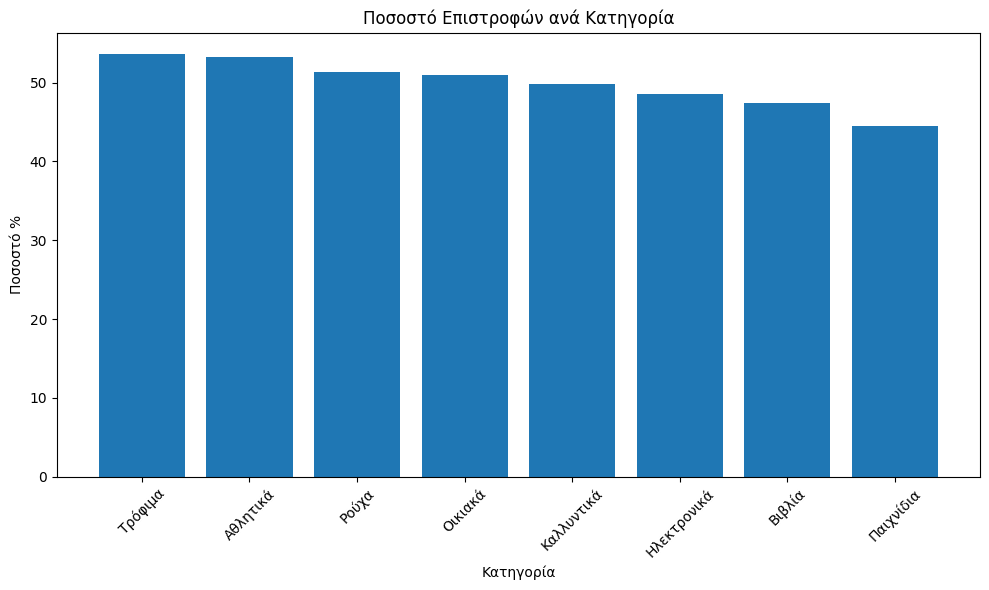

In [7]:
import matplotlib.pyplot as plt

# Bar chart για κατηγορίες
plt.figure(figsize=(10, 6))
plt.bar(category_returns['Κατηγορία'], category_returns['Ποσοστό_Επιστροφών'])
plt.title('Ποσοστό Επιστροφών ανά Κατηγορία')
plt.xlabel('Κατηγορία')
plt.ylabel('Ποσοστό %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()